In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Reshape, Conv1D, MaxPooling1D, Flatten, Dense, UpSampling1D, LeakyReLU
from tensorflow.keras import Sequential

def simple_autoencoder():
    autoencoder = Sequential([
        # Encoder
        Input(shape=(1000, 1)),
        Conv1D(64, 3, padding='same'),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2, padding='same'),
        Conv1D(32, 3, padding='same'),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2, padding='same'),
        Flatten(),

        # Bottleneck
        Dense(128, activation='relu'),

        # Decoder
        Dense(32*250, activation='relu'),
        Reshape((250, 32)),
        UpSampling1D(2),
        Conv1D(32, 3, padding='same'),
        LeakyReLU(alpha=0.1),
        UpSampling1D(2),
        Conv1D(64, 3, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv1D(1, 3, activation='tanh', padding='same'),
    ])

    return autoencoder

2023-12-14 00:09:43.854347: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 00:09:43.856652: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 00:09:43.902096: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 00:09:43.903468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 00:09:44.713562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
DIR = "../data/Raw/logRaws/"

NUM_SAMPLES = 2662
NUM_FEATURES = 1
NUM_FRAMES = 1000

file_names = os.listdir(DIR)
input_array = np.empty((NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES))

# prepare data
def read_files(DIR):
    all_files = os.listdir(DIR)

    input_data = np.empty((0, 1), float)

    for file in all_files:
        file_path = os.path.join(DIR, file)
        df = pd.read_csv(file_path, usecols=[1, 16], header=None)
        if df.shape[0] < 999:
            continue

        df.columns = ['frame', 'accel_x']
        df_input = df[['accel_x']]
        df_input = df_input.astype('float32')

        input_data = np.append(input_data, df_input, axis=0)
    input_data = input_data.reshape(NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES)

    # divide by 16 to normalize
    input_data = input_data / 16

    return input_data

input_data = read_files(DIR)

input_data.shape


(2662, 1000, 1)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(input_data, test_size=0.2, random_state=42)

# compile autoencoder
autoencoder = simple_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# train autoencoder
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_test, X_test))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 64)          256       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1000, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 500, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 32)           6176      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 500, 32)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 250, 32)           0         
 g1D)                                                   

17/17 [==============================] - 0s 18ms/step


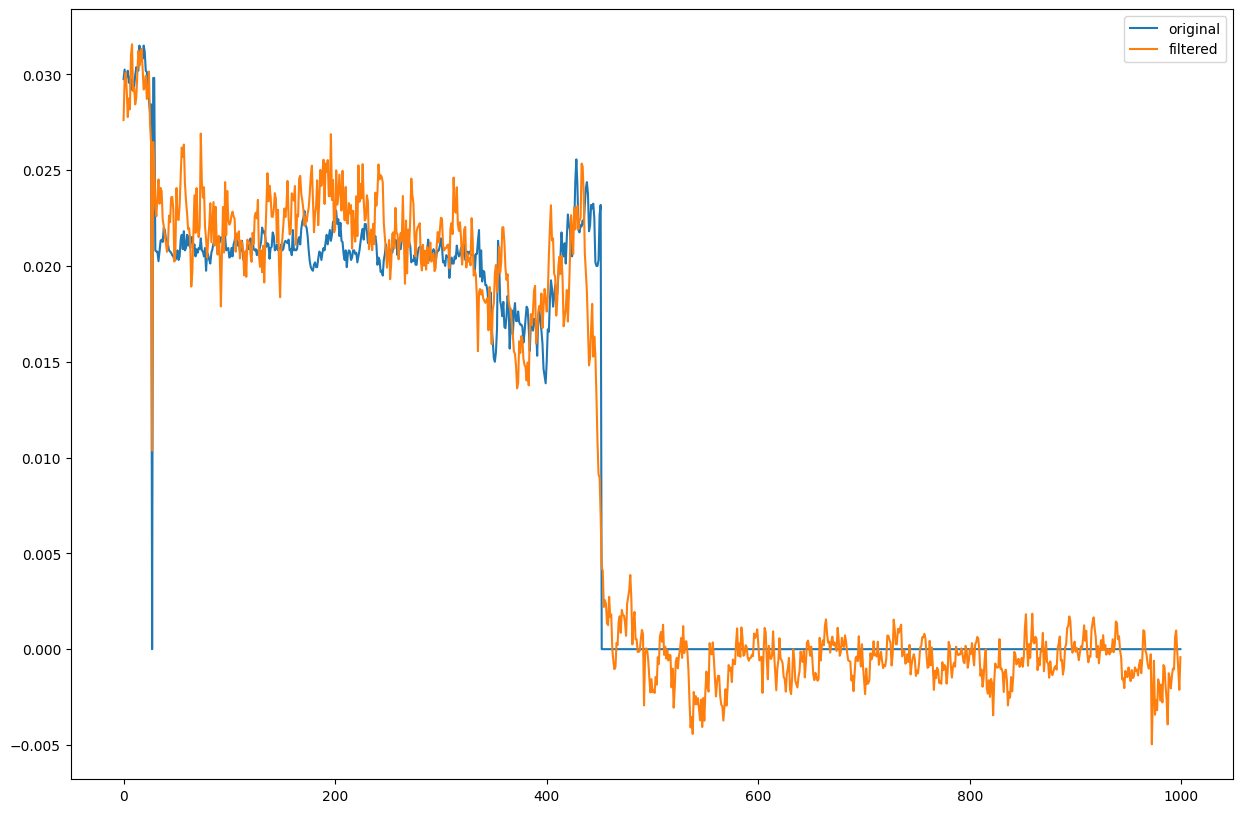

In [6]:
import matplotlib.pyplot as plt

filtered_data = autoencoder.predict(X_test)

INDEX = 70

plt.figure(figsize=(15, 10))
plt.plot(X_test[INDEX])
plt.plot(filtered_data[INDEX])
plt.legend(['original', 'filtered'])
plt.show()
